In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
import h5py
from pyscf import gto, scf
from icecream import ic

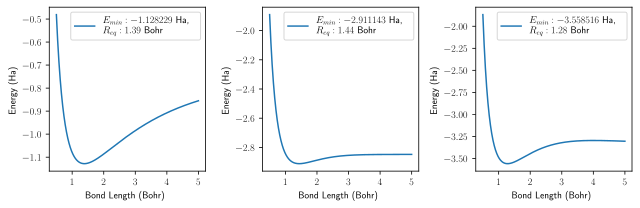

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
# config backend SVG
%config InlineBackend.figure_format = 'svg'

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Read data from HDF5 file
with h5py.File('./molecular_data.h5', 'r') as f:
    molecules = ['H2', 'HeH+', 'HeHe']
    data = {mol: {'energies': f[mol]['energies'][:], 'bond_lengths': f[mol]['bond_lengths'][:]} for mol in molecules}

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# Plot data on each subplot
for ax, mol in zip(axs, molecules):
    energies = data[mol]['energies']
    bond_lengths = data[mol]['bond_lengths']
    min_energy = min(energies)
    min_energy_index = np.argmin(energies)
    bond_length_at_min_energy = bond_lengths[min_energy_index]

    start_bond_length = 0.5
    index_start = np.argmin(np.abs(bond_lengths - start_bond_length))

    ax.plot(bond_lengths[index_start:], energies[index_start:], label='$E_{{min}}: {:.6f}$ Ha, \n$R_{{eq}}: {:.2f}$ Bohr'.format(min_energy, bond_length_at_min_energy))

    ax.set_xlabel(r'Bond Length (Bohr)')
    ax.set_ylabel(r'Energy (Ha)')
    ax.legend()

# Adjust layout and display plot
plt.tight_layout()
plt.show()

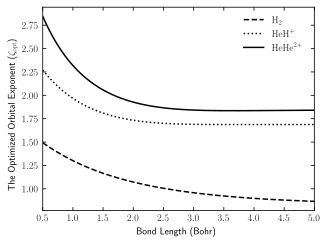

In [8]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Read data from HDF5 file
with h5py.File('./molecular_data.h5', 'r') as f:
    molecules = ['H2', 'HeH+', 'HeHe']
    molecules_names = [r'$\mathrm{H}_{2}$', r'$\mathrm{HeH}^{+}$', r'$\mathrm{HeHe}^{2+}$']
    data = {mol: {'alphas': f[mol]['alphas'][:], 'bond_lengths': f[mol]['bond_lengths'][:]} for mol in molecules}

# Create figure
height = 3.5
width = height * 1.318
fig, ax = plt.subplots(figsize=(width, height))

# Define line styles
line_styles = ['k--', 'k:', 'k-']

# Plot data for each molecule
for name, mol, line_style in zip(molecules_names, molecules, line_styles):
    alphas = data[mol]['alphas']
    bond_lengths = data[mol]['bond_lengths']
    ax.plot(bond_lengths, alphas, line_style, label=name)
    
ax.set_xlim(min(bond_lengths), max(bond_lengths))
ax.set_xlabel(r'Bond Length (Bohr)')
ax.set_ylabel(r'The Optimized Orbital Exponent ($\zeta_{\mathrm{opt}}$)')
ax.legend(frameon=False)

# Show minor ticks on all axes
# ax.minorticks_on()
ax.tick_params(which='both', direction='in', top=True, right=True)

# Adjust layout and display plot
plt.tight_layout()
plt.show()

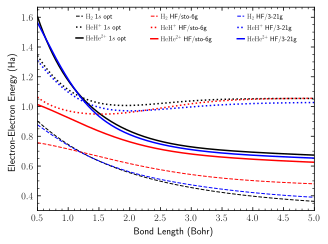

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf
import os

# Enable LaTeX rendering for plots
plt.rcParams['text.usetex'] = True

# Constants
HDF5_FILE_PATH = './molecular_data.h5'
MOLECULES = ['H2', 'HeH+', 'HeHe']
MOL_NAMES_Latex = [r'$\mathrm{H}_{2}$', r'$\mathrm{HeH}^{+}$', r'$\mathrm{HeHe}^{2+}$']
BASIS_SETS = ['sto-6g', '3-21g']

def read_hdf5_data(file_path, molecules):
    with h5py.File(file_path, 'r') as f:
        data = {
            mol: {
                'ee_energies': f[mol]['ee_energies'][:],
                'bond_lengths': f[mol]['bond_lengths'][:]
            }
            for mol in molecules
        }
    return data

def read_pyscf_data(file_path, molecules):
    with h5py.File(file_path, 'r') as f:
        data = {
            mol: f[mol]['ee_energies'][:] for mol in molecules
        }
    return data

def calculate_electron_electron_energy(atom_coords, charge, basis):
    mol = gto.Mole()
    mol.unit = 'bohr'
    mol.atom = atom_coords
    mol.charge = charge
    mol.basis = basis
    mol.build()

    mf = scf.RHF(mol)
    mf.verbose = 0
    mf.kernel()

    E_EE = mf.scf_summary['e2']

    return E_EE

def compute_electron_energies(data, basis):
    e_electron_energies = {}

    for mol in MOLECULES:
        bond_lengths = data[mol]['bond_lengths']
        energies = []

        for R in bond_lengths:
            if mol == 'HeH+':
                atom_coords = f'He 0 0 0; H 0 0 {R}'
                charge = 1
            elif mol == 'HeHe':
                atom_coords = f'He 0 0 0; He 0 0 {R}'
                charge = 2
            elif mol == 'H2':
                atom_coords = f'H 0 0 0; H 0 0 {R}'
                charge = 0
            else:
                raise ValueError(f"Unknown molecule: {mol}")

            E_EE = calculate_electron_electron_energy(atom_coords, charge, basis)
            energies.append(E_EE)

        e_electron_energies[mol] = np.array(energies)

    return e_electron_energies

def save_pyscf_data(file_path, data):
    with h5py.File(file_path, 'w') as f:
        for mol, energies in data.items():
            grp = f.create_group(mol)
            grp.create_dataset('ee_energies', data=energies)

def plot_electron_energies(data, pyscf_energies, molecules, molecule_names, basis_sets):
    height = 3.5
    width = height * 1.318
    fig, ax = plt.subplots(figsize=(width, height))

    hdf5_line_styles = ['k--', 'k:', 'k-']
    pyscf_line_styles = ['r--', 'r:', 'r-', 'b--', 'b:', 'b-']

    for name, mol, style in zip(molecule_names, molecules, hdf5_line_styles):
        ee_energies = data[mol]['ee_energies']
        bond_lengths = data[mol]['bond_lengths']
        linewidth = 1 if '--' in style else None
        ax.plot(bond_lengths, ee_energies, style, label=name + ' 1$s$ opt', linewidth=linewidth)

    for basis, color in zip(basis_sets, ['r', 'b']):
        for mol, style in zip(molecules, pyscf_line_styles[:len(molecules)]):
            bond_lengths = data[mol]['bond_lengths']
            energies = pyscf_energies[basis][mol]
            label = f"{molecule_names[MOLECULES.index(mol)]} HF/{basis}"
            linewidth = 1 if '--' in style else None
            ax.plot(bond_lengths, energies, style.replace('r', color), label=label, linewidth=linewidth)

    ax.set_xlim(np.min([data[mol]['bond_lengths'] for mol in molecules]),
                np.max([data[mol]['bond_lengths'] for mol in molecules]))
    ax.set_xlabel(r'Bond Length (Bohr)')
    ax.set_ylabel(r'Electron-Electron Energy (Ha)')

    ax.legend(
        frameon=False, 
        ncol=3,
        fontsize='x-small',  # Smaller font size
        loc='upper right', 
        markerscale=0.6,  # Smaller marker scale
        handlelength=1.0,  # Shorter handle length
        handletextpad=0.4,
        borderaxespad=0.5,
        )

    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True)
    plt.savefig(f'./ee_energy_1s_comparison.svg')
    plt.tight_layout()
    plt.show()
def main():
    data = read_hdf5_data(HDF5_FILE_PATH, MOLECULES)

    pyscf_energies = {}
    for basis in BASIS_SETS:
        output_file_path = f'./molecular_data_pyscf_hf_{basis}.h5'
        if os.path.exists(output_file_path):
            pyscf_energies[basis] = read_pyscf_data(output_file_path, MOLECULES)
        else:
            pyscf_energies[basis] = compute_electron_energies(data, basis)
            save_pyscf_data(output_file_path, pyscf_energies[basis])

    plot_electron_energies(data, pyscf_energies, MOLECULES, MOL_NAMES_Latex, BASIS_SETS)

if __name__ == "__main__":
    main()

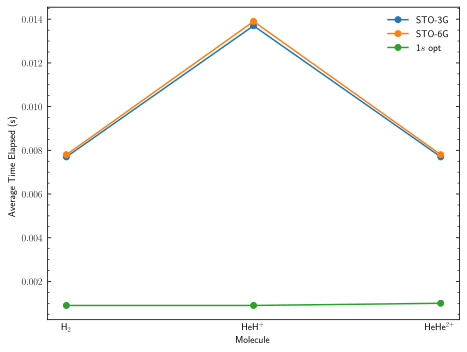

In [10]:
import time
import pandas as pd
import numpy as np
from pyscf import gto, scf
from scipy.optimize import fmin_l_bfgs_b
import scipy as scp
import matplotlib.pyplot as plt
import os

os.environ['OMP_NUM_THREADS'] = '16'

# Constants
MOLECULES = ['H2', 'HeH+', 'HeHe']
BASIS_SETS = ['sto-3g', 'sto-6g']
EQUILIBRIUM_BOND_LENGTHS = {
    'H2': {'sto-3g': 1.35, 'sto-6g': 1.34, '3-21g': 1.39},
    'HeH+': {'sto-3g': 1.76, 'sto-6g': 1.60, '3-21g': 1.38},
    'HeHe': {'sto-3g': 1.68, 'sto-6g': 1.69, '3-21g': 1.28}
}
NUM_RUNS = 10000

# Function to calculate total energy using PySCF
def calculate_total_energy(atom_coords, charge, basis):
    mol = gto.Mole()
    mol.unit = 'bohr'
    mol.atom = atom_coords
    mol.charge = charge
    mol.basis = basis
    mol.build()

    mf = scf.RHF(mol)
    mf.verbose = 0
    
    start_time = time.time()
    mf.kernel()
    end_time = time.time()

    elapsed_time = end_time - start_time

    # get time taken to calculate the energy of the molecule
    return elapsed_time

# Function to calculate total energy using analytical method optimized by scipy
def calculate_optimized_energy(species, R, species_Z):
    def w(alpha, R):
        return alpha * R

    def S(r):
        return (1 + r + (r**2 / 3)) * np.exp(-r)

    def S_(r):
        return (1 - r + (r**2 / 3)) * np.exp(r)

    def J(r):
        return -1 / r + np.exp(-2 * r) * (1 + 1 / r)

    def K(r):
        return -np.exp(-r) * (1 + r)

    def J_(r):
        term = (1 + (11 / 8) * r + (3 / 4) * r**2 + (1 / 6) * r**3) * np.exp(-2 * r)
        return (1 / r) * (1 - term)

    def Ei(w):
        return scp.special.expi(w)

    def K_(r):
        f_ = Ei(-4 * r)
        f__ = Ei(-2 * r)
        
        A = S_(r)
        term1 = (25/8 - (23/4)*r - 3*r**2 - (1/3)*r**3) * np.exp(-2 * r)
        term2 = (0.5772 + np.log(r)) * (S(r)**2)
        term3 = (A**2) * f_
        term4 = 2 * A * S(r) * f__
        
        try:
            result = (1 / 5) * (term1 + (6 / r) * (term2 + term3 - term4))
            return float(result)
        except:
            return complex((1 / 5) * (term1 + (6 / r) * (term2 + term3 - term4)))

    def L(r):
        return (np.exp(-r) * (r + 1/8 + 5/(16*r)) +
                np.exp(-3*r) * (-1/8 - 5/(16*r)))

    def KE(alpha, R, c):
        w_val = w(alpha, R)
        numerator = (alpha**2 * (1 - 4*c*K(w_val) - 8*c**2*K(w_val)*S(w_val) -
                                 4*c**2*S(w_val)**2 + 2*c**2 - 4*c**3*K(w_val) + c**4))
        denominator = 1 + 4*c*S(w_val) + 4*c**2*S(w_val)**2 + 2*c**2 + 4*c**3*S(w_val) + c**4
        return numerator / denominator

    def numerator1(Z, alpha, c, w_val):
        return (2 * Z * (-alpha * (1 + 2*c*S(w_val) + c**2) +
                alpha*K(w_val)*(2*c + 4*c**2*S(w_val) + 2*c**3) +
                alpha*J(w_val)*(c**2 + 2*c**3*S(w_val) + c**4)))

    def numerator2(Z, alpha, c, w_val):
        return (2 * Z * (-alpha * (c**2 + 2*c**3*S(w_val) + c**4) +
                alpha*K(w_val)*(2*c + 4*c**2*S(w_val) + 2*c**3) +
                alpha*J(w_val)*(1 + 2*c*S(w_val) + c**2)))

    def PE(alpha, R, c, Z1, Z2):
        w_val = w(alpha, R)
        num1 = numerator1(Z1, alpha, c, w_val)
        num2 = numerator2(Z2, alpha, c, w_val)
        denum1 = 1 + 4*c*S(w_val) + 4*c**2*S(w_val)**2 + 2*c**2 + 4*c**3*S(w_val) + c**4
        num3 = alpha * (5/8 * (1 + c**4) + 4 * L(w_val) * (c + c**3) +
                         2 * c**2 * J_(w_val) + 4 * c**2 * K_(w_val))
        return (num1 + num2 + num3) / denum1 + Z1 * Z2 / R

    def NE(alpha, R, c, Z1, Z2):
        w_val = w(alpha, R)
        num1 = numerator1(Z1, alpha, c, w_val)
        num2 = numerator2(Z2, alpha, c, w_val)
        denum1 = 1 + 4*c*S(w_val) + 4*c**2*S(w_val)**2 + 2*c**2 + 4*c**3*S(w_val) + c**4
        return (num1 + num2) / denum1

    def ee(alpha, R, c, Z1, Z2):
        w_val = w(alpha, R)
        denum1 = 1 + 4*c*S(w_val) + 4*c**2*S(w_val)**2 + 2*c**2 + 4*c**3*S(w_val) + c**4
        num3 = alpha * (5/8 * (1 + c**4) + 4 * L(w_val) * (c + c**3) +
                         2 * c**2 * J_(w_val) + 4 * c**2 * K_(w_val))
        return num3 / denum1

    def NN(alpha, R, c, Z1, Z2):
        return Z1 * Z2 / R

    def heh_1s_energy(alpha, r, c):
        return KE(alpha, r, c) + PE(alpha, r, c, Z1=2, Z2=1)

    def h2_1s_energy(alpha, r, c):
        return KE(alpha, r, c) + PE(alpha, r, c, Z1=1, Z2=1)

    def hehe_1s_energy(alpha, r, c):
        return KE(alpha, r, c) + PE(alpha, r, c, Z1=2, Z2=2)

    def objective(params, R, species, species_Z):
        alpha, c = params
        Z1, Z2 = species_Z[species]
        if species == 'HeH+':
            return heh_1s_energy(alpha, R, c)
        elif species == 'H2':
            return h2_1s_energy(alpha, R, c)
        elif species == 'HeHe':
            return hehe_1s_energy(alpha, R, c)
        else:
            raise ValueError("Unsupported species")

    # Retrieve atomic numbers for the species
    Z1, Z2 = species_Z[species]

    # Initial guess for alpha and c
    initial_guess = [1.0, 0.1]
    
    # Bounds for alpha and c
    bounds = [(0.1, 5.0), (0.01, 1.0)]
    
    # Perform optimization using L-BFGS-B algorithm
    result = fmin_l_bfgs_b(
        func=objective,
        x0=initial_guess,
        bounds=bounds,
        approx_grad=True,
        args=(R, species, species_Z)
    )
    alpha_opt, c_opt = result[0]
    
    # Calculate optimized energy components
    ke_energy = KE(alpha_opt, R, c_opt)
    ne_energy = NE(alpha_opt, R, c_opt, Z1, Z2)
    ee_energy = ee(alpha_opt, R, c_opt, Z1, Z2)
    nn_energy = NN(alpha_opt, R, c_opt, Z1, Z2)
    energy_opt = ke_energy + ne_energy + ee_energy + nn_energy
    
    return energy_opt

# Create a DataFrame to store the elapsed times
elapsed_times = pd.DataFrame(index=MOLECULES, columns=BASIS_SETS)

# Mapping species to their respective atomic numbers (Z1, Z2)
species_Z = {
    'HeH+': (2, 1),
    'H2': (1, 1),
    'HeHe': (2, 2)
}

# Calculate elapsed times for PySCF with different basis sets
for basis in BASIS_SETS:

    csv_path = f'calc_{basis}.csv'
    if os.path.exists(csv_path):
        # Read from CSV if it exists
        elapsed_times[basis] = pd.read_csv(csv_path, index_col=0).iloc[:, 0]
    else:
        # Perform calculations and save to CSV
        for mol in MOLECULES:
        
            bond_length = EQUILIBRIUM_BOND_LENGTHS[mol][basis]
            times = []
            
            for _ in range(NUM_RUNS):
                
                if mol == 'HeH+':
                    atom_coords = f'He 0 0 0; H 0 0 {bond_length}'
                    charge = 1
                elif mol == 'HeHe':
                    atom_coords = f'He 0 0 0; He 0 0 {bond_length}'
                    charge = 2
                elif mol == 'H2':
                    atom_coords = f'H 0 0 0; H 0 0 {bond_length}'
                    charge = 0
                else:
                    raise ValueError(f"Unknown molecule: {mol}")

                elapsed_time = calculate_total_energy(atom_coords, charge, basis)
                times.append(elapsed_time)
            
            times = np.array(times)
            avg_time = np.mean(times)
            std_time = np.std(times)
            elapsed_times.loc[mol, basis] = f"{avg_time:.4f} ± {std_time:.4f}"
        
        # Save to CSV
        elapsed_times[[basis]].to_csv(csv_path)

# Calculate elapsed times for the analytical method optimized by scipy
optimized_csv_path = 'calc_optimized_1s.csv'
if os.path.exists(optimized_csv_path):
    # Read from CSV if it exists
    elapsed_times['1s optimized'] = pd.read_csv(optimized_csv_path, index_col=0).iloc[:, 0]
else:
    # Perform calculations and save to CSV
    for mol in MOLECULES:
        bond_length = EQUILIBRIUM_BOND_LENGTHS[mol]['3-21g']  # Using '3-21g' bond length for optimized method
        times = []
        
        for _ in range(NUM_RUNS):
            start_time = time.time()
            
            calculate_optimized_energy(mol, bond_length, species_Z)
            
            end_time = time.time()
            elapsed_time = end_time - start_time
            times.append(elapsed_time)
        
        times = np.array(times)
        avg_time = np.mean(times)
        std_time = np.std(times)
        elapsed_times.loc[mol, '1s optimized'] = f"{avg_time:.4f} ± {std_time:.4f}"
    
    # Save to CSV
    elapsed_times[['1s optimized']].to_csv(optimized_csv_path)

# Extract average times for plotting
avg_times = elapsed_times.apply(lambda x: x.map(lambda y: float(str(y).split(' ± ')[0])))

# Create scatter plot
height = 5
width = height * 1.318
fig, ax = plt.subplots(figsize=(width, height))

latex_mol_name = ['H$_2$', 'HeH$^+$', 'HeHe$^{2+}$']

for basis in avg_times.columns:
    if "opt" not in basis:
        label = basis.upper()
    else:
        label = '1$s$ opt'
    ax.plot(latex_mol_name, avg_times[basis], 'o-', label=label)

# Add labels and legend
ax.set_xlabel('Molecule')
ax.set_ylabel('Average Time Elapsed (s)')
# ax.set_yscale('log')
# ax.set_title('Average Time Elapsed for Different Molecules and Basis Sets')
ax.legend(frameon=False)
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=0)
ax.tick_params(axis='y', which='both', direction='in', top=True, right=True)
ax.minorticks_on()
ax.xaxis.set_minor_locator(plt.NullLocator())  # Remove minor ticks from x-axis
# enable major ticks on x-axis
# ax.xaxis.set_major_locator(plt.MultipleLocator(1))

# Show plot
plt.tight_layout()
plt.savefig('time_elapsed_comparison.svg', bbox_inches='tight')
plt.show()